In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import nltk as tk
from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# replace <PATd:/spofrte/modeH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# load model
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
                    [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)


def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)  # * -1
    return token_type_ids, ref_token_type_ids


def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids


def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)


def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids,
                                                 position_ids=position_ids)

    return input_embeddings, ref_input_embeddings
def predict_qt(question, text):

    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)

    ground_truth = '13'


    start_scores, end_scores = predict(input_ids, \
                                       token_type_ids=token_type_ids, \
                                       position_ids=position_ids, \
                                       attention_mask=attention_mask)


    print('Question: ', question)
    print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    return input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, 

def explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, ):
    lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

    attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                                    baselines=ref_input_ids,
                                                    additional_forward_args=(
                                                    token_type_ids, position_ids, attention_mask, 0),
                                                    internal_batch_size=4,
                                                    return_convergence_delta=True)
    attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                                additional_forward_args=(
                                                token_type_ids, position_ids, attention_mask, 1),
                                                internal_batch_size=4,
                                                return_convergence_delta=True)

    attributions_start_sum = summarize_attributions(attributions_start)
    attributions_end_sum = summarize_attributions(attributions_end)
    # storing couple samples in an array for visualization purposes
    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        torch.argmax(start_scores),
        str(ground_truth),
        attributions_start_sum.sum(),
        all_tokens,
        delta_start)

    end_position_vis = viz.VisualizationDataRecord(
        attributions_end_sum,
        torch.max(torch.softmax(end_scores[0], dim=0)),
        torch.argmax(end_scores),
        torch.argmax(end_scores),
        str(ground_truth),
        attributions_end_sum.sum(),
        all_tokens,
        delta_end)
    print(all_tokens)
    print('\033[1m', 'Visualizations For Start Position', '\033[0m')
    viz.visualize_text([start_position_vis])

    print('\033[1m', 'Visualizations For End Position', '\033[0m')

    print("attributions_start_sum:   ", len(attributions_start_sum))
    print("all tokens:    ", len(all_tokens))
    
    print(torch.max(torch.softmax(end_scores[0], dim=0)), 
      torch.argmax(end_scores),
      torch.argmax(end_scores),
      torch.max(torch.softmax(start_scores[0], dim=0)))
    
    return all_tokens, attributions_start_sum



def pred_explain(question, text):
    input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth , all_tokens,  = predict_qt(question,text)

    all_tokens, attributions_start_sum = explain(input_ids, ref_input_ids, token_type_ids, position_ids, attention_mask, start_scores, end_scores, ground_truth, all_tokens, )
    
    return all_tokens, attributions_start_sum, start_scores, end_scores



In [43]:
question = "Where is the Asian influence strongest in Victoria?"
text= """Immigrants arrived from all over the world to search for gold, especially from Ireland and China. Many Chinese miners worked in Victoria, and their legacy is particularly strong in Bendigo and its environs. Although there was some racism directed at them, there was not the level of anti-Chinese violence that was seen at the Lambing Flat riots in New South Wales. However, there was a riot at Buckland Valley near Bright in 1857. Conditions on the gold fields were cramped and unsanitary; an outbreak of typhoid at Buckland Valley in 1854 killed over 1,000 miners.My name is guo zikun. I am 25 years old."""

l_attributions = []
l_start_score = []
l_end_score = []

tokens = tk.sent_tokenize(text)
all_tokens, attributions_start_sum, start_scores, end_scores = pred_explain(question, text)
end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
l_attributions.append(torch.sum(attributions_start_sum)/len(all_tokens))
l_start_score.append(start_score)
l_end_score.append(end_score)
print("attribution average value : ", torch.sum(attributions_start_sum)/len(all_tokens))
print("start_scores :   ", start_score, " end_scores  : ", end_score)

for token in tokens:
    all_tokens, attributions_start_sum, start_scores, end_scores = pred_explain(question, token)
    end_score = float(torch.max(torch.softmax(end_scores[0], dim=0)))
    start_score = float(torch.max(torch.softmax(start_scores[0], dim=0)))
    l_attributions.append(torch.sum(attributions_start_sum)/len(all_tokens))
    l_start_score.append(start_score)
    l_end_score.append(end_score)
    print("attribution average value : ", torch.sum(attributions_start_sum)/len(all_tokens))
    print("start_scores :   ", start_score, " end_scores  : ", end_score)
    


Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  bend ##igo
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'immigrants', 'arrived', 'from', 'all', 'over', 'the', 'world', 'to', 'search', 'for', 'gold', ',', 'especially', 'from', 'ireland', 'and', 'china', '.', 'many', 'chinese', 'miners', 'worked', 'in', 'victoria', ',', 'and', 'their', 'legacy', 'is', 'particularly', 'strong', 'in', 'bend', '##igo', 'and', 'its', 'en', '##vir', '##ons', '.', 'although', 'there', 'was', 'some', 'racism', 'directed', 'at', 'them', ',', 'there', 'was', 'not', 'the', 'level', 'of', 'anti', '-', 'chinese', 'violence', 'that', 'was', 'seen', 'at', 'the', 'lamb', '##ing', 'flat', 'riots', 'in', 'new', 'south', 'wales', '.', 'however', ',', 'there', 'was', 'a', 'riot', 'at', 'buck', '##land', 'valley', 'near', 'bright', 'in', '1857', '.', 'conditions', 'on', 'the', 'gold', 'fields', 'were', 'cramped', 'and', 'un', '##san', '#

 Visualizations For End Position 
attributions_start_sum:    146
all tokens:     146
tensor(0.5288, device='cuda:0', grad_fn=<MaxBackward1>) tensor(44, device='cuda:0') tensor(44, device='cuda:0') tensor(0.9752, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0300, device='cuda:0', dtype=torch.float64)
start_scores :    0.9751545190811157  end_scores  :  0.5288310050964355
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'immigrants', 'arrived', 'from', 'all', 'over', 'the', 'world', 'to', 'search', 'for', 'gold', ',', 'especially', 'from', 'ireland', 'and', 'china', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    30
all tokens:     30
tensor(0.2826, device='cuda:0', grad_fn=<MaxBackward1>) tensor(25, device='cuda:0') tensor(25, device='cuda:0') tensor(0.3672, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0700, device='cuda:0', dtype=torch.float64)
start_scores :    0.36720752716064453  end_scores  :  0.2825678586959839
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  bend ##igo
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'many', 'chinese', 'miners', 'worked', 'in', 'victoria', ',', 'and', 'their', 'legacy', 'is', 'particularly', 'strong', 'in', 'bend', '##igo', 'and', 'its', 'en', '##vir', '##ons', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    34
all tokens:     34
tensor(0.8435, device='cuda:0', grad_fn=<MaxBackward1>) tensor(26, device='cuda:0') tensor(26, device='cuda:0') tensor(0.9917, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.1041, device='cuda:0', dtype=torch.float64)
start_scores :    0.9916783571243286  end_scores  :  0.8434978723526001
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  lamb ##ing flat riots in new south wales
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'although', 'there', 'was', 'some', 'racism', 'directed', 'at', 'them', ',', 'there', 'was', 'not', 'the', 'level', 'of', 'anti', '-', 'chinese', 'violence', 'that', 'was', 'seen', 'at', 'the', 'lamb', '##ing', 'flat', 'riots', 'in', 'new', 'south', 'wales', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    45
all tokens:     45
tensor(0.3248, device='cuda:0', grad_fn=<MaxBackward1>) tensor(42, device='cuda:0') tensor(42, device='cuda:0') tensor(0.3864, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(-0.0538, device='cuda:0', dtype=torch.float64)
start_scores :    0.38644838333129883  end_scores  :  0.32482630014419556
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  buck ##land valley
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'however', ',', 'there', 'was', 'a', 'riot', 'at', 'buck', '##land', 'valley', 'near', 'bright', 'in', '1857', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    27
all tokens:     27
tensor(0.5057, device='cuda:0', grad_fn=<MaxBackward1>) tensor(20, device='cuda:0') tensor(20, device='cuda:0') tensor(0.8965, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0439, device='cuda:0', dtype=torch.float64)
start_scores :    0.896506130695343  end_scores  :  0.5057384967803955
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  buck ##land valley
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'conditions', 'on', 'the', 'gold', 'fields', 'were', 'cramped', 'and', 'un', '##san', '##ita', '##ry', ';', 'an', 'outbreak', 'of', 'ty', '##ph', '##oid', 'at', 'buck', '##land', 'valley', 'in', '1854', 'killed', 'over', '1', ',', '000', 'miners', '.', 'my', 'name', 'is', 'guo', 'z', '##ik', '##un', '.', '[SEP]']
 Visualizations For Start Position 


 Visualizations For End Position 
attributions_start_sum:    52
all tokens:     52
tensor(0.4686, device='cuda:0', grad_fn=<MaxBackward1>) tensor(33, device='cuda:0') tensor(33, device='cuda:0') tensor(0.5256, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(-0.0047, device='cuda:0', dtype=torch.float64)
start_scores :    0.5255535244941711  end_scores  :  0.4685663878917694
Question:  Where is the Asian influence strongest in Victoria?
Predicted Answer:  victoria ? [SEP] i am 25 years old .
['[CLS]', 'where', 'is', 'the', 'asian', 'influence', 'strongest', 'in', 'victoria', '?', '[SEP]', 'i', 'am', '25', 'years', 'old', '.', '[SEP]']
 Visualizations For Start Position 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
8,8 (0.29),13,0.42,[CLS] where is the asian influence strongest in victoria ? [SEP] i am 25 years old . [SEP]


 Visualizations For End Position 
attributions_start_sum:    18
all tokens:     18
tensor(0.1598, device='cuda:0', grad_fn=<MaxBackward1>) tensor(16, device='cuda:0') tensor(16, device='cuda:0') tensor(0.2856, device='cuda:0', grad_fn=<MaxBackward1>)
attribution average value :  tensor(0.0236, device='cuda:0', dtype=torch.float64)
start_scores :    0.2855788767337799  end_scores  :  0.15982255339622498


In [44]:
li = []
for i in l_attributions:
    temp = torch.Tensor.cpu(i)
    li.append(temp)
l_attributions = li

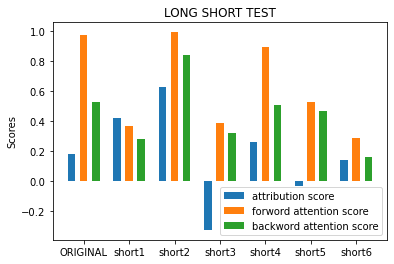

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

label = []
l_attributions = [i*6 for i in l_attributions]
for i in range(len(l_attributions)):
    if i == 0:
        label.append("ORIGINAL")
    else :
        label.append("short" + str(i))


data = [l_attributions, l_start_score, l_end_score]


def create_multi_bars(labels, datas, tick_step=1, group_gap=0.2, bar_gap=0):
    '''
    labels : x轴坐标标签序列
    datas ：数据集，二维列表，要求列表每个元素的长度必须与labels的长度一致
    tick_step ：默认x轴刻度步长为1，通过tick_step可调整x轴刻度步长。
    group_gap : 柱子组与组之间的间隙，最好为正值，否则组与组之间重叠
    bar_gap ：每组柱子之间的空隙，默认为0，每组柱子紧挨，正值每组柱子之间有间隙，负值每组柱子之间重叠
    '''
    # ticks为x轴刻度
    ticks = np.arange(len(labels)) * tick_step
    # group_num为数据的组数，即每组柱子的柱子个数
    group_num = len(datas)
    # group_width为每组柱子的总宽度，group_gap 为柱子组与组之间的间隙。
    group_width = tick_step - group_gap
    # bar_span为每组柱子之间在x轴上的距离，即柱子宽度和间隙的总和
    bar_span = group_width / group_num
    # bar_width为每个柱子的实际宽度
    bar_width = bar_span - bar_gap
    # baseline_x为每组柱子第一个柱子的基准x轴位置，随后的柱子依次递增bar_span即可
    baseline_x = ticks - (group_width - bar_span) / 2
    for index, y in enumerate(datas):
        if index == 0:
            plt.bar(baseline_x + index*bar_span, y, bar_width, label='attribution score')
        if index == 1:
            plt.bar(baseline_x + index*bar_span, y, bar_width, label='forword attention score')
        if index == 2:
            plt.bar(baseline_x + index*bar_span, y, bar_width, label='backword attention score')
    plt.ylabel('Scores')
    plt.title('LONG SHORT TEST')
    # x轴刻度标签位置与x轴刻度一致
    plt.xticks(ticks, labels)
    plt.legend()
       

create_multi_bars(label, data, bar_gap=0.1)
